# Importando Librerías Requeridas

In [363]:
#imports
import numpy as np
import pandas as pd
import scipy
from math import sqrt
import matplotlib.pyplot as plt
from matplotlib import colors

#estimators
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.linear_model import LinearRegression
#from sklearn.svm import SVR
from sklearn import svm
#from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

#model metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

#cross validation
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

#Ordinal Encoding
from sklearn.preprocessing import OrdinalEncoder

#OneHot Encoding
from sklearn.preprocessing import OneHotEncoder

#Calibration Curve
from sklearn.calibration import calibration_curve

# Importando Datos

In [414]:
#data
rawData = pd.read_csv('/Users/nrodriguez/Documents/PythonProjects/creditONEFinalV3.csv', header=0)
rawData.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,BILL_AMT1,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month
0,20000,2,2,1,24,2,3913,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2682,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,29239,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,46990,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,8617,2000,36681,10000,9000,689,679,0


# Estructura de los Datos

In [415]:
rawData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 14 columns):
LIMIT_BAL                     30000 non-null int64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
BILL_AMT1                     30000 non-null int64
PAY_AMT1                      30000 non-null int64
PAY_AMT2                      30000 non-null int64
PAY_AMT3                      30000 non-null int64
PAY_AMT4                      30000 non-null int64
PAY_AMT5                      30000 non-null int64
PAY_AMT6                      30000 non-null int64
default_payment_next_month    30000 non-null int64
dtypes: int64(14)
memory usage: 3.2 MB


# Preparación de los Datos

In [416]:
#Ordinal Encoding

encoder = OrdinalEncoder()
rawData.EDUCATION = encoder.fit_transform(rawData.EDUCATION.values.reshape(-1,1))
rawData.AGE = encoder.fit_transform(rawData.AGE.values.reshape(-1,1))

for payCont in (rawData.filter(regex='PAY_\d+')) :
    #print('Ordinal', payCont)
    rawData[payCont] = encoder.fit_transform(rawData[payCont].values.reshape(-1,1))
    
    
#OneHot Encoding

oneHot = OneHotEncoder(dtype=np.int, sparse=True)
nominals = pd.DataFrame(oneHot.fit_transform(rawData[['SEX','MARRIAGE']])\
                        .toarray(),
                        columns=['FEMALE','MALE','MARRIED','SINGLE','DIVORCE','OTHERS'])
rawData = rawData.drop(['SEX'],axis=1)
rawData = rawData.drop(['MARRIAGE'],axis=1)
rawData = pd.concat([rawData,nominals],axis=1)

#Transforma Variable Dependiente en Categorica
#rawData['default_payment_next_month'] = rawData['default_payment_next_month'].map({0:'NO MOROSO', 1:'MOROSO'})
rawData['default_payment_next_month'] = rawData['default_payment_next_month'].astype('category')

rawData.head()

/Users/nrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


,LIMIT_BAL,EDUCATION,AGE,PAY_0,BILL_AMT1,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month,FEMALE,MALE,MARRIED,SINGLE,DIVORCE,OTHERS
0,20000,2.0,3.0,4.0,3913,0,689,0,0,0,0,1,0,1,0,1,0,0
1,120000,2.0,5.0,1.0,2682,0,1000,1000,1000,0,2000,1,0,1,0,0,1,0
2,90000,2.0,13.0,2.0,29239,1518,1500,1000,1000,1000,5000,0,0,1,0,0,1,0
3,50000,2.0,16.0,2.0,46990,2000,2019,1200,1100,1069,1000,0,0,1,0,1,0,0
4,50000,2.0,36.0,1.0,8617,2000,36681,10000,9000,689,679,0,1,0,0,1,0,0


# Selección de Variables

In [417]:
#features
features = rawData.iloc[:,0:23]
print('Summary of feature sample')
features.head()

Summary of feature sample


,LIMIT_BAL,EDUCATION,AGE,PAY_0,BILL_AMT1,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month,FEMALE,MALE,MARRIED,SINGLE,DIVORCE,OTHERS
0,20000,2.0,3.0,4.0,3913,0,689,0,0,0,0,1,0,1,0,1,0,0
1,120000,2.0,5.0,1.0,2682,0,1000,1000,1000,0,2000,1,0,1,0,0,1,0
2,90000,2.0,13.0,2.0,29239,1518,1500,1000,1000,1000,5000,0,0,1,0,0,1,0
3,50000,2.0,16.0,2.0,46990,2000,2019,1200,1100,1069,1000,0,0,1,0,1,0,0
4,50000,2.0,36.0,1.0,8617,2000,36681,10000,9000,689,679,0,1,0,0,1,0,0


# Selección de Variable Dependiente

In [418]:
#dependent variable
depVar = rawData['default_payment_next_month']

# Training Set Features

In [419]:
#Training Set (Feature Space: X Training)
X_train = (features[: 21000])
X_train.head()

,LIMIT_BAL,EDUCATION,AGE,PAY_0,BILL_AMT1,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month,FEMALE,MALE,MARRIED,SINGLE,DIVORCE,OTHERS
0,20000,2.0,3.0,4.0,3913,0,689,0,0,0,0,1,0,1,0,1,0,0
1,120000,2.0,5.0,1.0,2682,0,1000,1000,1000,0,2000,1,0,1,0,0,1,0
2,90000,2.0,13.0,2.0,29239,1518,1500,1000,1000,1000,5000,0,0,1,0,0,1,0
3,50000,2.0,16.0,2.0,46990,2000,2019,1200,1100,1069,1000,0,0,1,0,1,0,0
4,50000,2.0,36.0,1.0,8617,2000,36681,10000,9000,689,679,0,1,0,0,1,0,0


# Training Set Variable Dependiente

In [420]:
#Dependent Variable Training Set (y Training)
y_train = depVar[: 21000]
y_train_count = len(y_train.index)
print('The number of observations in the Y training set are:',str(y_train_count))
y_train.head()

The number of observations in the Y training set are: 21000


0    1
1    1
2    0
3    0
4    0
Name: default_payment_next_month, dtype: category
Categories (2, int64): [0, 1]

# Testing Set Features

In [421]:
#Testing Set (X Testing)
X_test = features[-9000:]
X_test_count = len(X_test.index)
print('The number of observations in the feature testing set is:',str(X_test_count))
print(X_test.head())

The number of observations in the feature testing set is: 9000
       LIMIT_BAL  EDUCATION   AGE  PAY_0  BILL_AMT1  PAY_AMT1  PAY_AMT2  \
21000      30000        2.0  15.0    3.0          0       780         0   
21001     280000        3.0  19.0    4.0     178220     10000      9000   
21002     260000        2.0  16.0    2.0     128602      3203      6015   
21003     200000        2.0  11.0    4.0     160106      7600      4000   
21004      80000        2.0  11.0    4.0      79237      3000      4005   

       PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6 default_payment_next_month  \
21000      1170         0         0         0                          0   
21001      8000      6738      6974      7600                          1   
21002      5055      2011      4078      4522                          0   
21003         0         0         0         0                          1   
21004      2500     10000         0      5000                          1   

       FEMALE  MALE  MARRIED 

# Ground Truth

In [422]:
#Ground Truth (y_test) 
y_test = depVar[-9000:]
y_test_count = len(y_test.index)
print('The number of observations in the Y training set are:',str(y_test_count))
y_test.head()

The number of observations in the Y training set are: 9000


21000    0
21001    1
21002    0
21003    1
21004    1
Name: default_payment_next_month, dtype: category
Categories (2, int64): [0, 1]

# Cross Validation

In [423]:
#Implement Cross Validation anytime we need to by simply running the following on the X and Y training sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train)

#The shape function to double check that the split was made as needed
X_train.shape, X_test.shape

((15750, 18), (5250, 18))

# Tuning Parameters and Models Definition

In [434]:
#Models
#max_iter > 25000 igual resultado que con 100000, < 25000 baja el Score
#gamma='scale' mal resultado
#SVM con max_iter 1000 bajo desempeño
# Classification Models
modelSVM = svm.SVC(gamma='scale', max_iter=10000, decision_function_shape='ovo', random_state=None)
modelKNN = KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',metric_params=None, n_jobs=1, n_neighbors=10, p=2,weights='uniform')
modelGNB = GaussianNB()

#modelDTC = DecisionTreeClassifier(max_depth=5)
#modelRFC = RandomForestClassifier(n_estimators=100)
#modelGB = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
#modelSVM = svm.SVC(gamma='scale', max_iter=1000, decision_function_shape='ovo', random_state=None)
#modelKNN = KNeighborsClassifier(algorithm='auto', leaf_size=5, metric='minkowski',metric_params=None, n_jobs=5, n_neighbors=10, p=2,weights='uniform')
#modelKNN = KNeighborsClassifier(algorithm='ball_tree', leaf_size=5, metric='minkowski',metric_params=None, n_jobs=5, n_neighbors=10, p=2,weights='distance')

# Regression Models
#modelSVR = SVR(gamma='auto',max_iter=25000)
#modelRF = RandomForestRegressor(n_jobs=5,max_depth=5, random_state=0,n_estimators=100)
#modelLR = LinearRegression(n_jobs=5, normalize=False, fit_intercept=False)

#features
print('Summary of feature sample')
features.head()

#dependent variable
#print(depVar)

Summary of feature sample


,LIMIT_BAL,EDUCATION,AGE,PAY_0,BILL_AMT1,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month,FEMALE,MALE,MARRIED,SINGLE,DIVORCE,OTHERS
0,20000,2.0,3.0,4.0,3913,0,689,0,0,0,0,1,0,1,0,1,0,0
1,120000,2.0,5.0,1.0,2682,0,1000,1000,1000,0,2000,1,0,1,0,0,1,0
2,90000,2.0,13.0,2.0,29239,1518,1500,1000,1000,1000,5000,0,0,1,0,0,1,0
3,50000,2.0,16.0,2.0,46990,2000,2019,1200,1100,1069,1000,0,0,1,0,1,0,0
4,50000,2.0,36.0,1.0,8617,2000,36681,10000,9000,689,679,0,1,0,0,1,0,0


# KNN Model Result

In [425]:
modelKNN.fit(X_train,y_train)
prediccionKNN = modelKNN.predict(X_test)
print("Accuracy Score: ",accuracy_score(y_test, prediccionKNN))
metrics.confusion_matrix(y_test,prediccionKNN)
print(prediccionKNN)

Accuracy Score:  0.7628571428571429
[0 0 0 ... 0 0 0]


# Support Vector Machine Model Result

In [426]:
modelSVM.fit(X_train,y_train)
prediccionSVM = modelSVM.predict(X_test)
print("Accuracy Score: ",accuracy_score(y_test, prediccionSVM))
metrics.confusion_matrix(y_test,prediccionSVM)
print(prediccionSVM)

/Users/nrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Accuracy Score:  0.7714285714285715
[0 0 0 ... 0 0 0]


# Gaussian Naive Bayes Model Result

In [427]:
modelGNB.fit(X_train,y_train)
prediccionGNB = modelGNB.predict(X_test)
print("Accuracy Score: ",accuracy_score(y_test, prediccionGNB))
#metrics.confusion_matrix(y_test,prediccionGB)
print(prediccionGNB)

Accuracy Score:  0.376
[1 1 0 ... 1 1 1]


# Plotting Resultados Predicciones

/Users/nrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


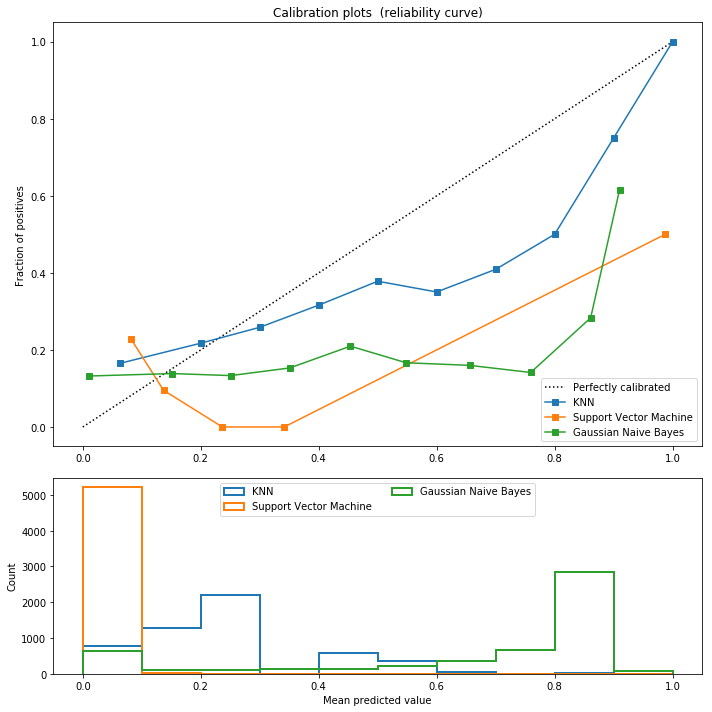

In [428]:
# Plot calibration plots

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(modelKNN, 'KNN'),
                  (modelSVM, 'Support Vector Machine'),
                  (modelGNB, 'Gaussian Naive Bayes')]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()